Checks for GEV probability integral transform and inverse.

In [112]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
import tensorflow as tf
from evtGAN import tf_utils, viz_utils
from scipy.stats import ecdf
from scipy.stats import genextreme, genpareto, uniform
from importlib import reload
reload(tf_utils)

plt.rcParams["font.family"] = "monospace"

# get indices from ravel indices
def translate_indices(i, dims=(18, 22)):
    indices = np.arange(0, dims[0] * dims[1], 1)
    x = np.argwhere(indices.reshape(dims[0], dims[1]) == i)
    return tuple(*map(tuple, x))

def translate_indices_r(i, j, dims=(18, 22)):
    indices = np.arange(0, dims[0] * dims[1], 1)
    x = indices.reshape(dims[0], dims[1])[i, j]
    return x


ntrain = 2000
conditions = "all"
dim_dict = {'wind_data': 'total', 'wave_data': 'hmax', 'precip_data': 'tp'}
hist_kwargs = {'color': 'lightgrey', 'alpha': .6, 'edgecolor': 'k', 'density': True}

variable = 'wave_data'
dim = dim_dict[variable]

datadir = f"/Users/alison/Documents/DPhil/multivariate/{variable}"
figdir = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures"

# Generate the train/test sets (optional save)

In [113]:
# load data
reload(tf_utils)
data, cyclone_flag = tf_utils.load_data(datadir, dim=dim)
train = data[:ntrain, ...]
test = data[ntrain:, ...]
x_valid, y_valid = np.where(np.std(train, axis=(0, 3)) > 0 ) # note coords with nonzero std
indices_valid = [translate_indices_r(i, j) for i, j in zip(x_valid, y_valid)]
ij = np.random.choice(indices_valid)
i, j = translate_indices(ij)

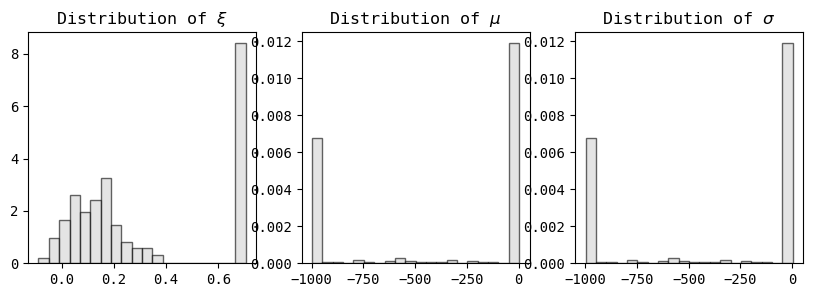

In [114]:
# load fitted parameters (pit_block_maxima.py)
marginals = np.load(os.path.join(datadir, 'train', 'bm', 'marginals.npy'))
images = np.load(os.path.join(datadir, 'train', 'bm', 'images.npy'))
params = np.load(os.path.join(datadir, 'train', 'bm', 'params.npy'))

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(-params[..., 0].ravel(), bins=20, **hist_kwargs);
axs[1].hist(params[..., 1].ravel(), bins=20, **hist_kwargs);  
axs[2].hist(params[..., 1].ravel(), bins=20, **hist_kwargs);   

axs[0].set_title(r'Distribution of $\xi$');
axs[1].set_title(r'Distribution of $\mu$');
axs[2].set_title(r'Distribution of $\sigma$');

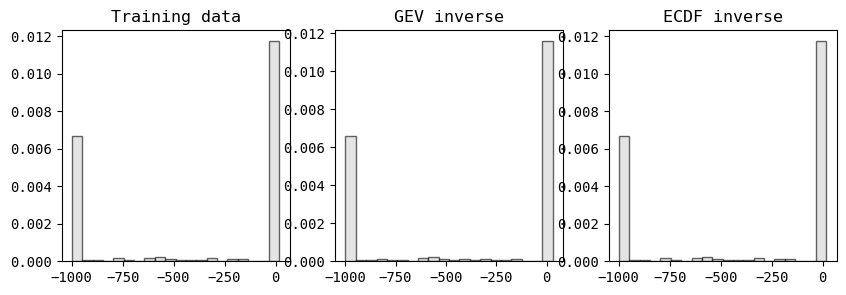

In [116]:
# check inverse transforms
inverse_para = tf_utils.inv_probability_integral_transform(marginals, params=params[..., np.newaxis], evt_type='bm')
inverse_nonpara = tf_utils.inv_probability_integral_transform(marginals, train, marginals)

fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].hist(train.ravel(), bins=20, **hist_kwargs);
ax[1].hist(inverse_para.ravel(), bins=20, **hist_kwargs);
ax[2].hist(inverse_nonpara.ravel(), bins=20, **hist_kwargs);

ax[0].set_title('Training data');
ax[1].set_title('GEV inverse');
ax[2].set_title('ECDF inverse');

# Examine results

In [118]:
from scipy.stats import goodness_of_fit, genextreme
reload(tf_utils)

# load fitted parameters (pit_block_maxima.py)
train = np.load(os.path.join(datadir, 'train', 'bm', 'images.npy'))
params = np.load(os.path.join(datadir, 'train', 'bm', 'params.npy'))

# load test set and marginals
test = np.load(os.path.join(datadir, 'test', 'bm', 'images.npy'))
marginals = np.load(os.path.join(datadir, 'test', 'bm', 'marginals.npy'))

# check inverse transforms
inverse_para = tf_utils.inv_probability_integral_transform(marginals, params=params[..., np.newaxis], evt_type='bm')
inverse_nonpara = tf_utils.inv_probability_integral_transform(marginals, test, marginals)

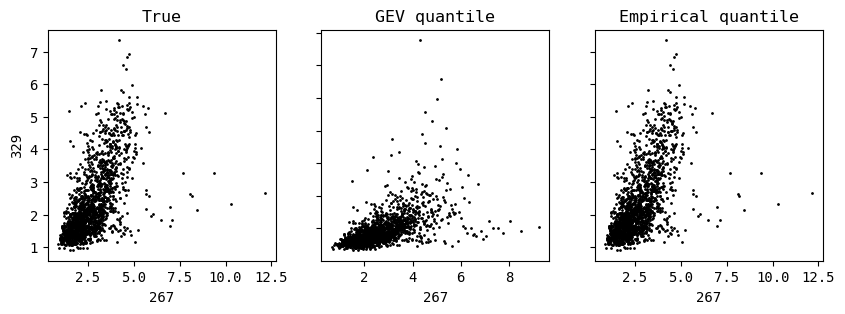

In [119]:
# Plot the scatter plots
channel = 0
data = test.copy()

fig, ax = plt.subplots(1, 3, figsize=(10, 3))

sample_pixels = np.random.choice(indices_valid, 2, replace=False)

n, h, w, c = data.shape
x0 = data.reshape(n, h * w, c)
x1 = inverse_para.reshape(n, h * w, c)
x2 = inverse_nonpara.reshape(n, h * w, c)

ax[0].scatter(x0[:, sample_pixels[0], 0], x0[:, sample_pixels[1], 0], color='k', s=1)
ax[1].scatter(x1[:, sample_pixels[0], 0], x1[:, sample_pixels[1], 0], color='k', s=1)
ax[2].scatter(x2[:, sample_pixels[0], 0], x2[:, sample_pixels[1], 0], color='k', s=1)

ax[0].set_title('True')
ax[1].set_title('GEV quantile')
ax[2].set_title('Empirical quantile');

for a in ax:
    a.set_xlabel(sample_pixels[0])
    a.set_ylabel(sample_pixels[1])
    a.label_outer()

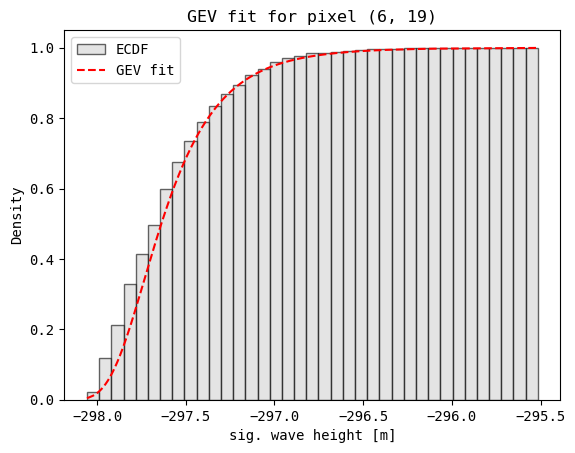

In [120]:
ij = np.random.choice(indices_valid)
i, j = translate_indices(ij)

x = sorted(test[:, i, j, 0])
y = sorted(marginals[:, i, j, 0])
gev = genextreme.cdf(x, *params[i, j, :])

fig, ax = plt.subplots(1)
ax.hist(x, cumulative=True, zorder=0, bins='auto', **hist_kwargs, label='ECDF')
ax.plot(x, gev, color='red', linestyle='--', label="GEV fit", zorder=1)
ax.legend();
ax.set_title('GEV fit for pixel ({}, {})'.format(i, j));
ax.set_xlabel(viz_utils.variable_labels[variable]);
ax.set_ylabel('Density');

(shape, loc, scale) = (-0.10, 2.68, 0.95)
Kolmogorov-Smirnoff test with H_0: data follows specified distribution
Test statistic: 0.0436
p-value: 0.0099


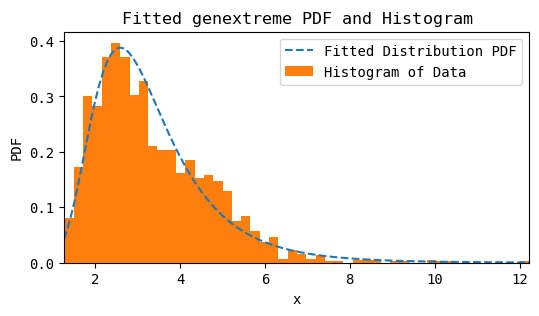

In [121]:
# goodness of fit test
# ij = np.random.choice(indices_valid, size=1)[0]
ij = 294
i, j = translate_indices(ij)

test_vec = train[:, i, j, 0].ravel()
shape, loc, scale = params[i, j]

res = goodness_of_fit(genextreme, test_vec, n_mc_samples=100, statistic='ks',  guessed_params={'c': shape, 'loc': loc, 'scale': scale})

print(f"(shape, loc, scale) = ({shape:.2f}, {loc:.2f}, {scale:.2f})")
print('Kolmogorov-Smirnoff test with H_0: data follows specified distribution')
print(f"Test statistic: {res.statistic:.4f}")
print(f"p-value: {res.pvalue:.4f}")

# plot results
fig, ax = plt.subplots(1, figsize=(6, 3))

res.fit_result.plot(ax=ax);
ax.set_xlim([min(test_vec), max(test_vec)]);

Text(0.5, 1.0, 'Uniformity of all transformed marginals')

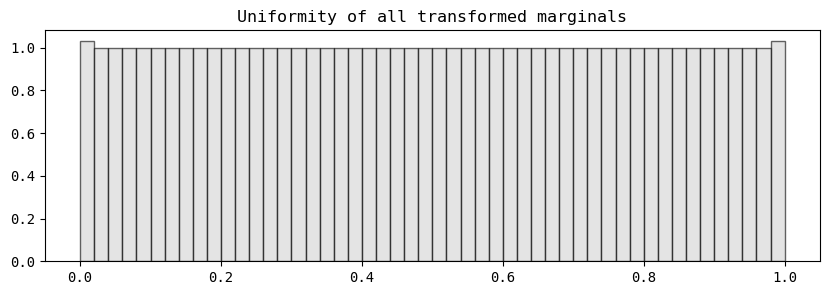

In [111]:
# plot all
fig, ax = plt.subplots(figsize=(10, 3))
ax.hist(marginals.ravel(), bins=50, **hist_kwargs);

ax.set_title('Uniformity of all transformed marginals')

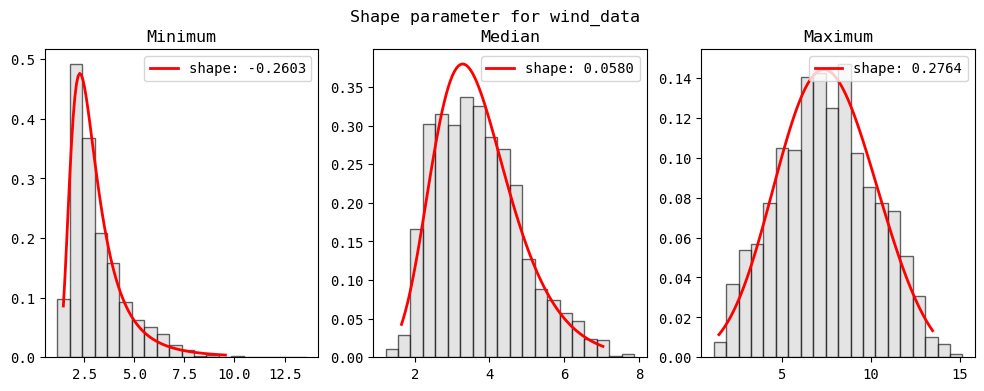

In [25]:
h, w, c = params.shape

shapes = [np.min(params[..., 0]), np.quantile(params[..., 0].ravel(), 0.5), np.max(params[..., 0])]
indices = [np.argmin(params[..., 0].ravel()), int((h * w) / 2), np.argmax(params[..., 0].ravel())]
indices = [translate_indices(ij) for ij in indices]
                 
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, c, index in zip(axs.ravel(), shapes, indices):
    
    y = train[:, index[0], index[1], 0]
    ax.hist(y, bins=20, **hist_kwargs)
    
    rv = genextreme(*params[index[0], index[1]])
    
    x = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
    ax.plot(x, rv.pdf(x), lw=2, label=f'shape: {c:.4f}', color='red')  
    ax.legend(loc='upper right');
    
axs[0].set_title('Minimum')
axs[1].set_title('Median')
axs[2].set_title('Maximum'); 

fig.suptitle(f'Shape parameter for {variable}');

fig.savefig(os.path.join(figdir, "general", f"fits_{variable}.png"), dpi=300, bbox_inches='tight')

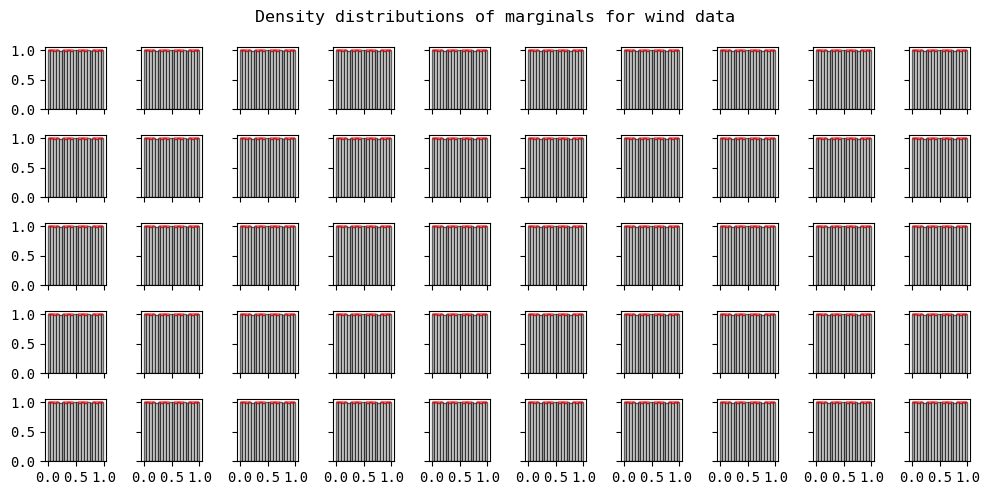

In [27]:
# histogram of marginals
from scipy.stats import uniform

fig, axs = plt.subplots(5, 10, figsize=(10, 5), layout='tight')

n, h, w, c = marginals.shape
indices = np.random.choice(indices_valid, size=50, replace=False)

# uniform for comparison
x = np.linspace(uniform.ppf(0.01), uniform.ppf(0.99), 50) 

for i, ax in zip(indices, axs.ravel()):
    _, bins, *_ = ax.hist(marginals.reshape(n, h * w, c)[..., i, 0].ravel(), alpha=0, bins=20, density=True)
    ax.hist(marginals.reshape(n, h * w, c)[..., i, 0].ravel(), bins=bins, **hist_kwargs)
    ax.plot(x, uniform.pdf(x), 'r--', lw=2, alpha=0.6)
    
    a, b = translate_indices(i)
    
    ax.set_xticks([0, .5, 1])
    ax.set_yticks([0, .5, 1])
    ax.label_outer()

fig.suptitle(f"Density distributions of marginals for {variable.replace('_', ' ')}");

# Howard (2022) plots

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_54335/1334441649.py:25: RuntimeWarning: divide by zero encountered in log
  uniform_expected = -np.log(-np.log(uniform_expected))[1:]


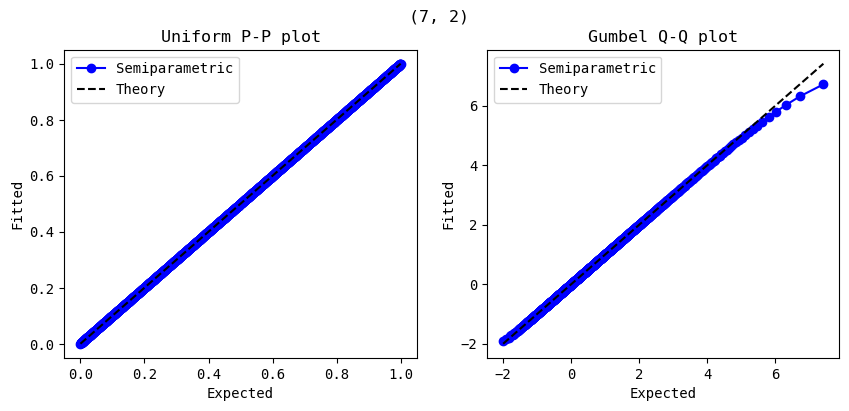

In [34]:
# goodness of fit test
ij = np.random.choice(indices_valid, size=1)[0]
i, j = translate_indices(ij)
n = len(marginals[:, i, j, 0])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
ax = axs[0]
y =  sorted(marginals[:, i, j, 0])
uniform_expected = sorted(np.linspace(0., 1., n))

ax.plot(uniform_expected, y, '-o', color='blue', label='Semiparametric')
ax.plot(uniform_expected, uniform_expected, color='k', linestyle='dashed', label='Theory')
ax.set_xlabel('Expected')
ax.set_ylabel('Fitted')
ax.legend(loc='upper left')
ax.set_title('Uniform P-P plot')

# plot 2
ax = axs[1]

y =  sorted(marginals[:, i, j, 0])
y = -np.log(-np.log(y))[1:]
uniform_expected = sorted(np.linspace(0., 1., n))
uniform_expected = -np.log(-np.log(uniform_expected))[1:]

ax.plot(uniform_expected, y, '-o', color='blue', label='Semiparametric')
ax.plot(uniform_expected, uniform_expected, color='k', linestyle='dashed', label='Theory')
ax.set_xlabel('Expected')
ax.set_ylabel('Fitted')
ax.legend(loc='upper left')
ax.set_title('Gumbel Q-Q plot');

fig.suptitle(f'({i}, {j})');
